HHU Methods of Artificial Intelligence in Life Sciences, Prof. Dr. Markus Kollmann, SS2020 

# Assignment 3: Contrastive Predictive Coding

## Exercise 2

This exercise was created by *Cornelius Crijnen* and *Tim Kaiser* for `Methods of AI in Life Sciences` based on this Paper:
https://arxiv.org/abs/1807.03748

---

### Implementing Contrastive Predictive Coding

In this assignment, we want to implement the Constrastive Predictive Coding (CPC) learning approach on the Wearable-dataset. The dataset contains interbeat intervals (ibi) for a number of patients as well as accuracy scores which estimate the quality of the measurements. Our goal is to learn useful representations of the data by trying to predict future parts of the sequences from the past ones. 


### Table of Contents

Read through the instructions carefully and make sure you provide clean and readable code.

1. Preparation and Hyperparameters
2. Data Setup
3. Implementing the CPC Model
4. Training and Evaluation

---

## Part I. Preparation and Hyperparameters

We start of by importing everything we need. We check for a cuda-enabled GPU in the system and set it up for PyTorch.
We set random seeds as well as parameters we will need in this notebook.

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(42)
torch.manual_seed(42);

cuda = torch.cuda.is_available()
print(f"Using GPU: {cuda}")

path = "./data"

timestep = 3
batch_size = 64
seq_len = 200

epochs = 10
learning_rate = 1e-3
betas = (0.9, 0.98)
eps = 1e-9
weight_decay = 1e-4
amsgrad = True

Using GPU: True


## Part II. Data Setup

The data is stored in the pickle-files `train_balanced.pickle` and `test.pickle`. Each of them contains a list of tuples. Each tuple corresponds to one example, containing a sequence of ibi-values, a sequence of accuracy scores, a label and the patient id. Each entry in the ibi-array corresponds to an entry in the accuracy-array. 

E.g. `data, acc, label, patient_id = train_data[0]` for the first example with
1. data: numpy-array of shape (200,)
2. acc: numpy-array of shape (200,)
3. label: integer 0 or 1 with 0 for non-Afib and 1 for Afib
4. patient_id: integer with patient ID

All sequences have been trimmed to be of length 200 and train data from `train_balanced.pickle` is balanced, meaning it contains an equal amount of Afib and non-Afib examples. 

Your task is to read in the data and feed it into two dataloaders, one for training and one for test.

Hint: The line 

`with open('path to data', 'rb') as file:
    data = pickle.load(file)`

accesses the file and stores it in `data`. You have to fill in the correct path for `'path to data'`. 

In [3]:
########################################################################
#                         START OF YOUR CODE                           #
########################################################################
class Wearable(Dataset):
    def __init__(self, path, train=True):
        if train:
            with open(os.path.join(path, 'train_balancedwork.pickle'), 'rb') as file:
                self.examples = pickle.load(file)
        else:
            with open(os.path.join(path, 'test.pickle'), 'rb') as file:
                self.examples = pickle.load(file)

    def __getitem__(self, item):
        return self.examples[item]

    def __len__(self):
        return len(self.examples)


path = '/home/ria/MMBSintern/bachelor/exercise/data'
train_data = Wearable(path, True)
test_data = Wearable(path, False)
########################################################################
#                          END OF YOUR CODE                            #       
########################################################################


print(len(test_data))


train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = DataLoader(test_data, batch_size=len(test_data), shuffle=False, num_workers=0) 

1805


In [4]:
for i, sample in enumerate(test_dl):
    print(sample)

[tensor([[ 600,  611,  612,  ...,  644,  610,  639],
        [ 859,  831,  850,  ...,  949,  814,  777],
        [ 841,  843,  833,  ...,  644,  748,  640],
        ...,
        [ 863,  870,  858,  ...,  874,  890, 1471],
        [ 671,  660,  651,  ...,  706,  691,  680],
        [ 770,  778,  755,  ...,  739,  734,  720]]), tensor([[ 7,  7,  7,  ...,  7,  6,  6],
        [ 9,  8, 10,  ...,  9,  8,  7],
        [15, 12, 15,  ..., 12, 15, 12],
        ...,
        [ 9,  8,  8,  ..., 15, 13, 15],
        [ 5,  5,  5,  ...,  5,  5,  5],
        [ 6,  8,  7,  ...,  5,  5,  5]]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([123, 197, 196,  ..., 188, 123, 196])]


In [5]:
labellist=[]
for i, sample in enumerate(test_dl):
    ibi, acc, label, patient = sample
    labellist.append(label)

# Concatenate all label tensors into a single tensor
labellist = torch.cat(labellist)

AFib = (labellist == 1).sum().item()  # Counts elements equal to 1
nonAFib = (labellist == 0).sum().item()  # Counts elements equal to 0


print(f'NonAFib count: {nonAFib} , AFib count: {AFib}')


NonAFib count: 1477 , AFib count: 328


In [6]:
328/(1477+328)

0.1817174515235457

## Part III. Implementing the CPC Model

Now we want to implement the model for CPC. The model is comprised of the following parts:

* Encoder: 
    1. Conv1d with 64 filters of size 3, stride 1, padding 1 and no bias
    2. BatchNorm1d
    3. ReLU activation
    4. Conv1d with 64 filters of size 3, stride 1, padding 1 and no bias
    5. BatchNorm1d
    6. ReLU activation
* GRU Layer with hidden_size 32, num_layers 1, bidirectional False, batch_first True
* `timestep` Linear Layers with 64 out_features (Hint: Have a look at `nn.ModuleList`)
* Log-Softmax Layer

Hint: Use `nn.Sequential` to define the blocks of the model.

In the forward pass, you need to:
1. Encode the input sequence `x` into a latent representation `z`
2. Sample an sequence-index `t` in `[0.4*seq_len, seq_len-timestep]`
3. Calculate the context `c_t` by
    1. Taking all `z_k` with `k` $\leq$ `t` (You might need to swap some dimensions of `z` beforehand)
    2. Obtain a context sequence `c` using the GRU Layer
    3. Pick out the context `c_t` (You might need to remove empty dimensions of `c_t`)

In [4]:
class CPC(nn.Module):
    def __init__(self, timestep, batch_size, seq_len):
        super().__init__()
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.timestep = timestep
        ########################################################################
        #                         START OF YOUR CODE                           #
        ########################################################################
        self.encoder = nn.Sequential(
            nn.Conv1d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
        )  # [bs, 64, seq_len]
        
        self.gru = nn.GRU(64, 32, num_layers=1, bidirectional=False,
                          batch_first=True)  # last layer=tanh, c=[-1,1]
        self.W = nn.ModuleList([nn.Linear(32, 64) for _ in range(timestep)])
        self.log_softmax = nn.LogSoftmax(dim=1)
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################
        def _weights_init(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # initialize gru
        for layer_p in self.gru._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    nn.init.kaiming_normal_(self.gru.__getattr__(p), mode='fan_out', nonlinearity='relu')

        self.apply(_weights_init)
    
    def init_hidden(self, batch_size, use_gpu=True):
        if use_gpu:
            return torch.zeros(1, batch_size, 32).cuda()
        else:
            return torch.zeros(1, batch_size, 32)

    def forward(self, x, hidden):
        # input sequence is [N, C, L], e.g. size [bs, 16, 200]
        batch_size = x.size(0)
        ########################################################################
        #                         START OF YOUR CODE                           #
        ########################################################################
        # encode sequence x
        z = self.encoder(x)  # encoded sequence is [N, C, L], e.g. size [bs, 64, 200]
        
        # sample t between [0.4*seq_len, seq_len-timestep]
        t = torch.randint(int(0.4 * z.size(2)), z.size(2) - self.timestep, size=(1,)).long()
        
        # calculate c_t: take all z_<=t and use them as input for the GRU
        z = z.transpose(1, 2)  # reshape to [N, L, C] for GRU, e.g. size [bs, 200, 64]
        forward_seq = z[:, :t+1, :]  # e.g. size [bs, t, 64]
        output, hidden = self.gru(forward_seq, hidden)  # output, e.g. size [bs, t, 32]
        c_t = output[:, t, :].view(batch_size, 32)  # c_t, e.g. size [bs, 32]
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################
        nce = 0
        for k in range(self.timestep):
            linear = self.W[k]
            z_tk = z[:, t+k+1].view(batch_size, 64)  # z_t+k, e.g. size [bs, 64]
            scores = linear(c_t) @ z_tk.T  # bilinear score: z_t+k * Wk * c_t, e.g. size [bs, bs]
            nce += self.log_softmax(scores).diag().sum() # nce is a tensor

        nce /= -1. * batch_size * self.timestep  # average over timestep and batch
        
        y = torch.arange(batch_size).to(x.device)
        accuracy = scores.argmax(1).eq_(y).float().mean()

        return nce, accuracy, hidden, c_t

    def predict(self, x, hidden):
        # input sequence is [N, C, L], e.g. size [bs, 16, 200]
        z = self.encoder(x)
        # encoded sequence is [N, C, L], e.g. size [bs, 64, 200]
        # reshape to [N, L, C] for GRU, e.g. size [bs, 200, 64]
        z = z.transpose(1, 2)
        output, hidden = self.gru(z, hidden)  # output, e.g. size [bs, 200, 32]

        return output, hidden
        # return output[:,-1,:], hidden # only return the last


def test_cpc():
    zeros = torch.zeros(64, 16, 40).float()
    model = CPC(3, 64, 40)
    hidden = model.init_hidden(64, False)
    out = model(zeros, hidden)
    print(out[3].size())
    
test_cpc() # You should see [64, 32]

torch.Size([64, 32])


### Part IV. Training and Evaluation

Lastly, we need to define training and evaluation functions. 

--- 

During trainnig, all you need to do is get the loss and accuracy from the model and then update the model using the optimizer. 

Before you can feed the data into the model however, you need to combine the ibi-sequence and accuracy-sequence as described in the lecture. Hence you should use a one-hot encoding of the accuracy into 16 channels, corresponding to the 16 quality scores. Then multiply the data with the one-hot encoded accuracy element-wise. This needs to be done for every incoming batch of data and accuracy sequences. 

You will need to call the `model.init_hidden()` for every iteration during training, since it is required by the forward pass of the model. You can do this with this line: `hidden = model.init_hidden(len(data), cuda).float()`

Don't forget to record the loss and accuracy for plotting (see return) and to print the loss and accuracy progress in regular intervals (e.g. after each epoch). Also, you should set everything up for training with a GPU by moving the appropriate Tensors onto the GPU. 

Please call the `evaluate()` function before the first and after each epoch, using the test_loader. 

--- 

For the evaluation, most of the code is already there. You have to perform the same merge of data and accuracy sequences as in the training function for the evaluation to work properly. 

We are evaluating the performance of the model on four patients by visualizing the latent space `c_t` using PCA. PCA is a method of dimensionality reduction which only keeps the dimensions which have the highest information content. 

In [5]:
def train(model, train_loader, test_loader, optimizer):
    ########################################################################
    #                         START OF YOUR CODE                           #
    ########################################################################
    if cuda:
        model = model.cuda()
    loss_hist = []
    accuracy_hist = []
    n = len(train_dl)
    for epoch in range(epochs):
        evaluate(model, test_loader)
        model.train()
        for i, (ibi, acc, _, _) in enumerate(train_loader):
            data = ibi.unsqueeze(2).float() * F.one_hot(acc, 16).float()  # add channel dimension
            data = data.permute(0, 2, 1)
            
            if cuda:
                data = data.cuda()
    
            hidden = model.init_hidden(len(data), cuda).float()
            loss, accuracy, _, _ = model(data, hidden)
            
            accuracy_hist.append(accuracy.item())
            loss_hist.append(loss.item())
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        avg_acc = np.mean(accuracy_hist[n*epoch:n*(epoch+1)])
        avg_loss = np.mean(loss_hist[n*epoch:n*(epoch+1)])
        print(f'Train epoch: {epoch+1:2d}, loss: {avg_loss:.3f}, acc: {avg_acc:.3f}')
    evaluate(model, test_loader)
    ########################################################################
    #                          END OF YOUR CODE                            #       
    ########################################################################
    return loss_hist, accuracy_hist

In [8]:
def evaluate(model, loader):
    if cuda:
        model = model.cuda()
        
    model.eval()
    with torch.no_grad():
        ibi, acc, label, patient_id = next(iter(loader))
        ########################################################################
        #                         START OF YOUR CODE                           #
        ########################################################################
        data = ibi.unsqueeze(2).float() * F.one_hot(acc, 16).float()  # add channel dimension
        data = data.permute(0, 2, 1)
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################
        idx = (patient_id == 145) + (patient_id == 106) + (patient_id == 116) + (patient_id == 176) 
        


        #idx = patient_id > 100
        
        data = data[idx]
        label_idx = label[idx]

        if cuda:
            data = data.float().cuda()
        
        hidden = model.init_hidden(len(data), cuda)
        output, _ = model.predict(data, hidden)
        c_t = output[:, -1].squeeze_()
        
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(c_t.cpu())
        plt.figure(figsize=(5, 5))
        plt.rc('axes', labelsize=18) 
        plt.rc('xtick', labelsize=15) 
        plt.rc('ytick', labelsize=15)
       
        plt.scatter(principal_components[label_idx == 0, 0], principal_components[label_idx == 0, 1],
                    s=40, color='#2283a2')
        plt.scatter(principal_components[label_idx == 1, 0], principal_components[label_idx == 1, 1],
                    s=40, color='#f66209')
        plt.xlabel('First Principle Component')
        plt.ylabel('Second Principle Component')
        plt.legend(['non-Afib', 'Afib'], prop={'size': 15})
        plt.show()

Instantiate the model, initialize the optimizer and run the training function. As usual, use the Adam Optimizer with the Hyperparameters from the top of the Notebook.

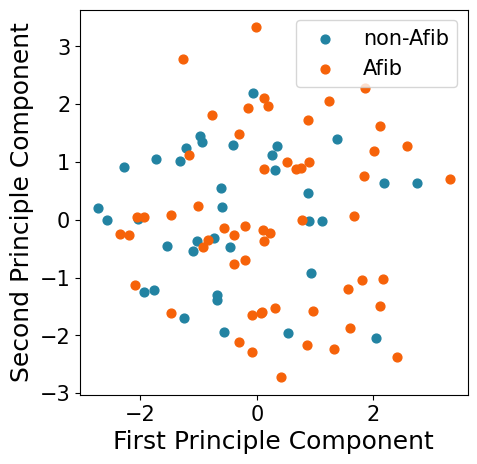

Train epoch:  1, loss: 1.989, acc: 0.276


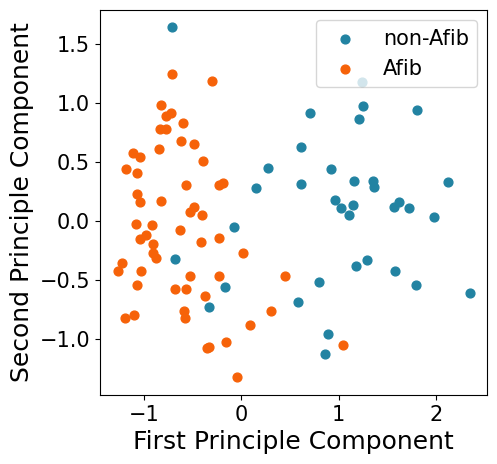

Train epoch:  2, loss: 0.653, acc: 0.584


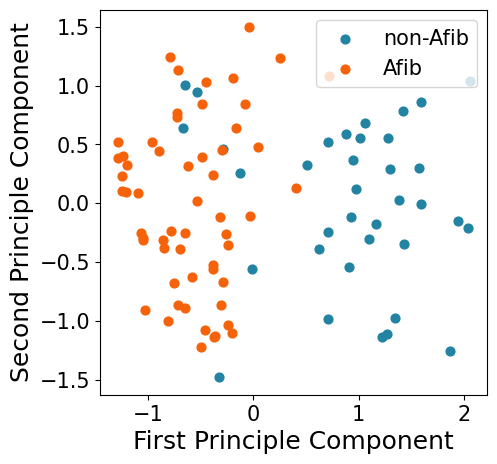

Train epoch:  3, loss: 0.442, acc: 0.690


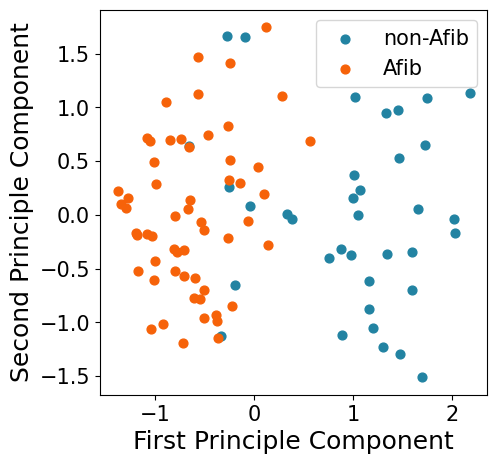

Train epoch:  4, loss: 0.358, acc: 0.732


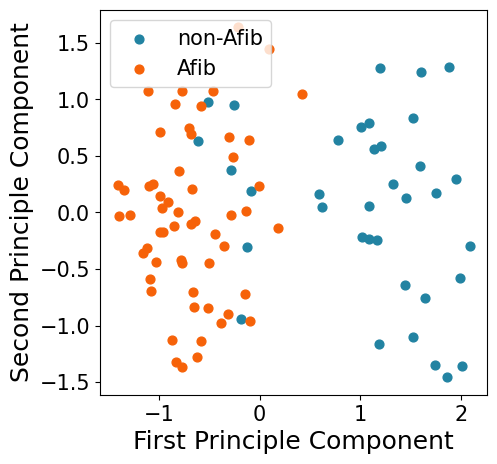

Train epoch:  5, loss: 0.306, acc: 0.765


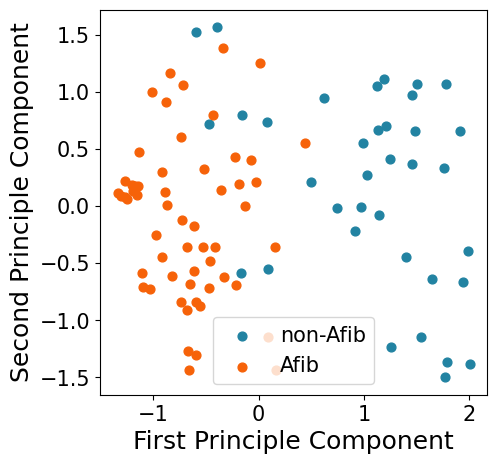

Train epoch:  6, loss: 0.274, acc: 0.785


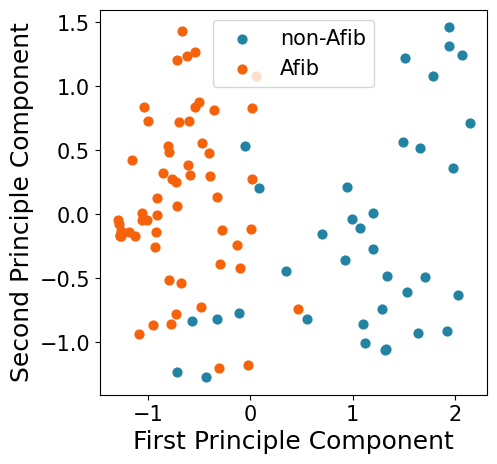

Train epoch:  7, loss: 0.249, acc: 0.803


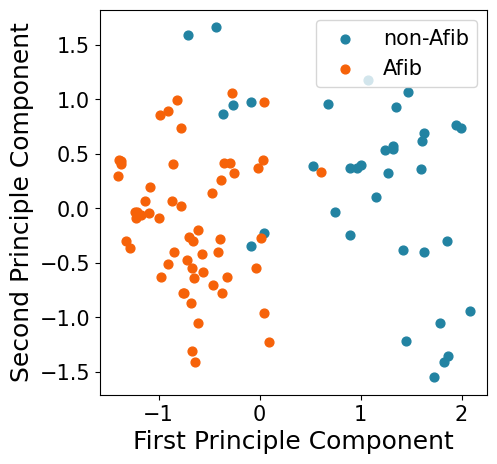

Train epoch:  8, loss: 0.221, acc: 0.824


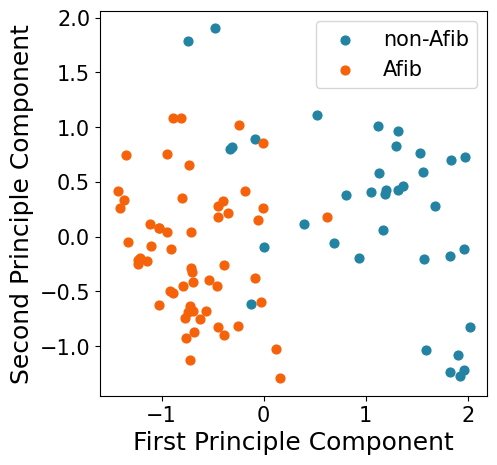

Train epoch:  9, loss: 0.210, acc: 0.833


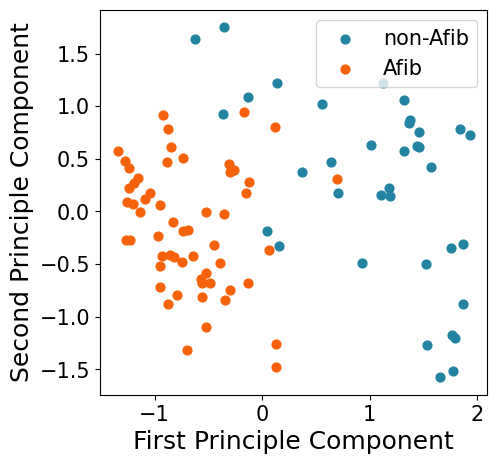

Train epoch: 10, loss: 0.197, acc: 0.840


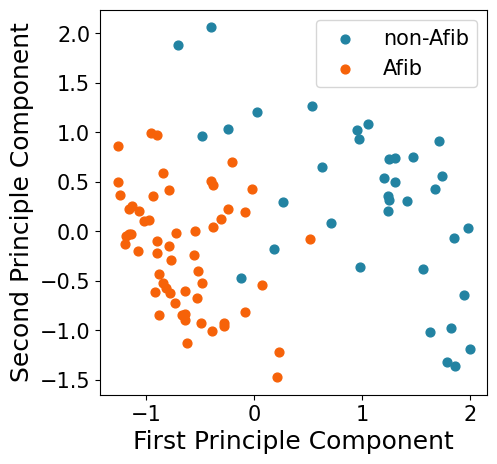

In [9]:
########################################################################
#                         START OF YOUR CODE                           #
########################################################################
model = CPC(timestep, batch_size, seq_len)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, eps=eps, 
                       weight_decay=weight_decay, amsgrad=amsgrad)
loss_hist, accuracy_hist = train(model, train_dl, test_dl, optimizer)
########################################################################
#                          END OF YOUR CODE                            #       
########################################################################

The final plot should look simliar to this: 

<img align="left" src="CPC_LatentSpace_10.png">

# Including all patient_ids

In [11]:
def evaluate(model, loader):
    if cuda:
        model = model.cuda()
        
    model.eval()
    with torch.no_grad():
        ibi, acc, label, patient_id = next(iter(loader))
        ########################################################################
        #                         START OF YOUR CODE                           #
        ########################################################################
        data = ibi.unsqueeze(2).float() * F.one_hot(acc, 16).float()  # add channel dimension
        data = data.permute(0, 2, 1)
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################
        # idx = (patient_id == 145) + (patient_id == 106) + (patient_id == 116) + (patient_id == 176) 


        idx = patient_id > 100
        
        data = data[idx]
        label_idx = label[idx]

        if cuda:
            data = data.float().cuda()
        
        hidden = model.init_hidden(len(data), cuda)
        output, _ = model.predict(data, hidden)
        c_t = output[:, -1].squeeze_()
        
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(c_t.cpu())
        plt.figure(figsize=(5, 5))
        plt.rc('axes', labelsize=18) 
        plt.rc('xtick', labelsize=15) 
        plt.rc('ytick', labelsize=15)
       
        plt.scatter(principal_components[label_idx == 0, 0], principal_components[label_idx == 0, 1],
                    s=40, color='#2283a2')
        plt.scatter(principal_components[label_idx == 1, 0], principal_components[label_idx == 1, 1],
                    s=40, color='#f66209')
        plt.xlabel('First Principle Component')
        plt.ylabel('Second Principle Component')
        plt.legend(['non-Afib', 'Afib'], prop={'size': 15})
        plt.show()

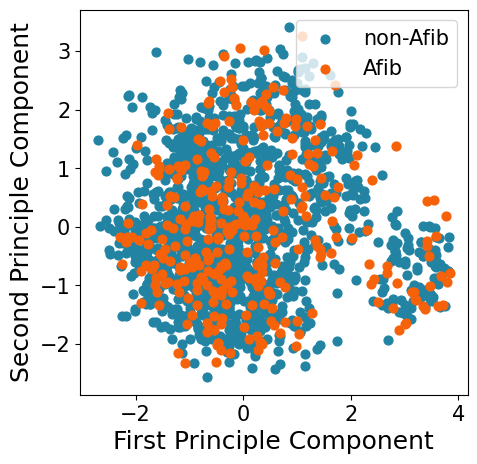

Train epoch:  1, loss: 2.030, acc: 0.284


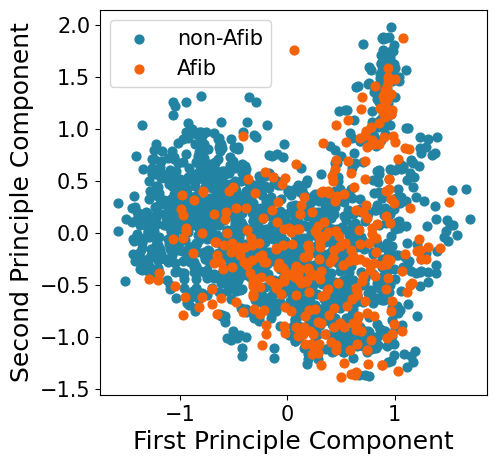

Train epoch:  2, loss: 0.635, acc: 0.607


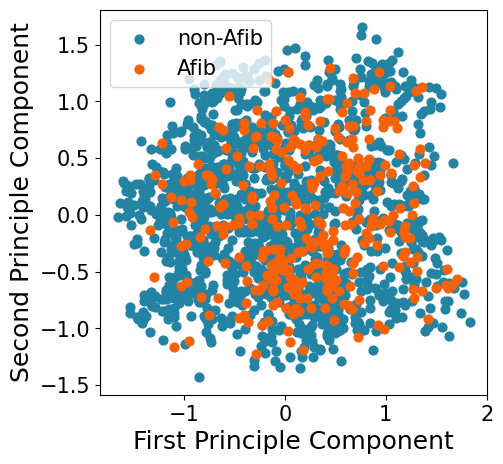

Train epoch:  3, loss: 0.422, acc: 0.707


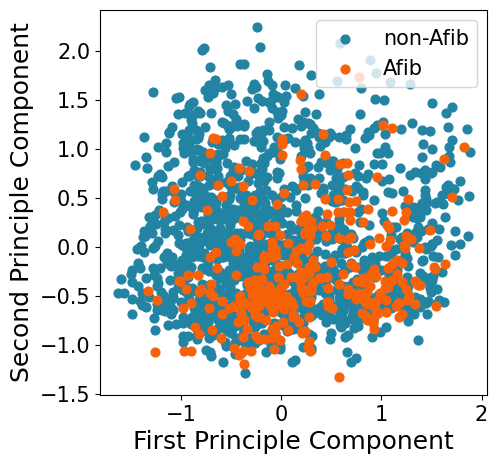

Train epoch:  4, loss: 0.345, acc: 0.750


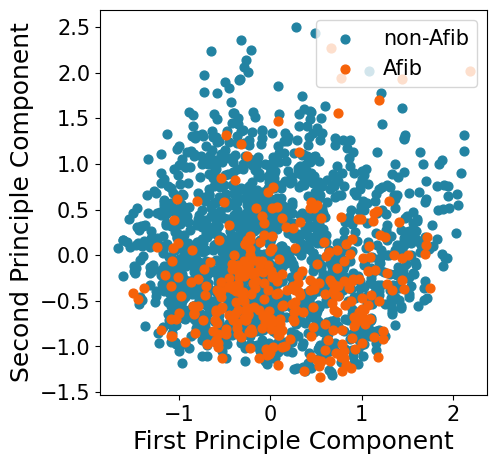

Train epoch:  5, loss: 0.304, acc: 0.769


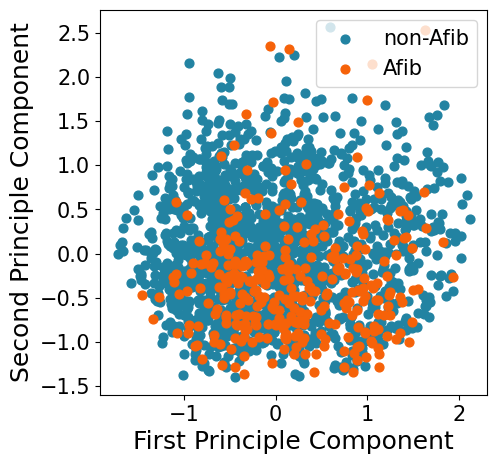

Train epoch:  6, loss: 0.269, acc: 0.796


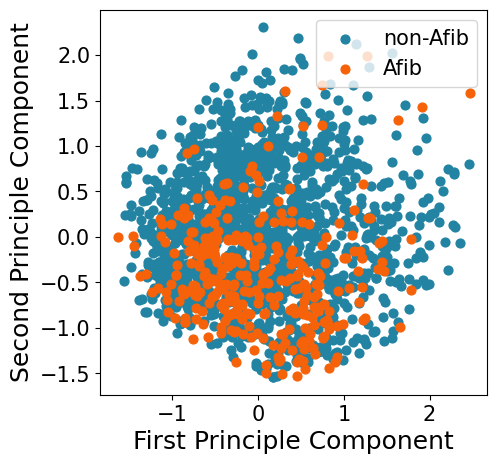

Train epoch:  7, loss: 0.241, acc: 0.813


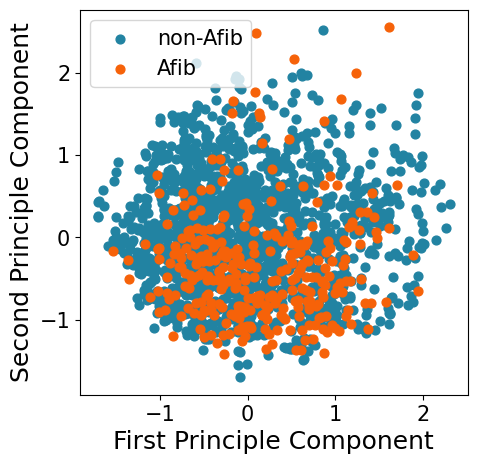

Train epoch:  8, loss: 0.224, acc: 0.824


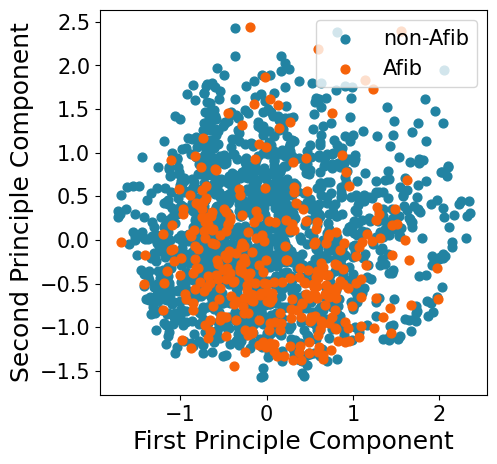

Train epoch:  9, loss: 0.206, acc: 0.839


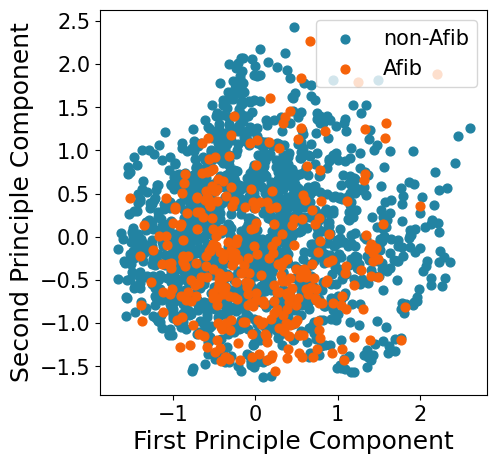

Train epoch: 10, loss: 0.194, acc: 0.852


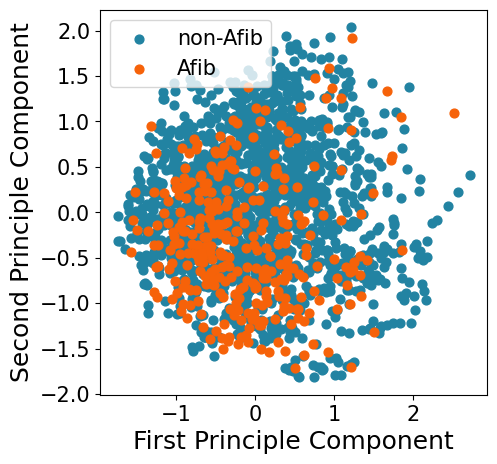

In [12]:
model = CPC(timestep, batch_size, seq_len)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, eps=eps, 
                       weight_decay=weight_decay, amsgrad=amsgrad)
loss_hist, accuracy_hist = train(model, train_dl, test_dl, optimizer)

Finally, plot the results by plotting `loss_hist` and `accuracy_hist`.

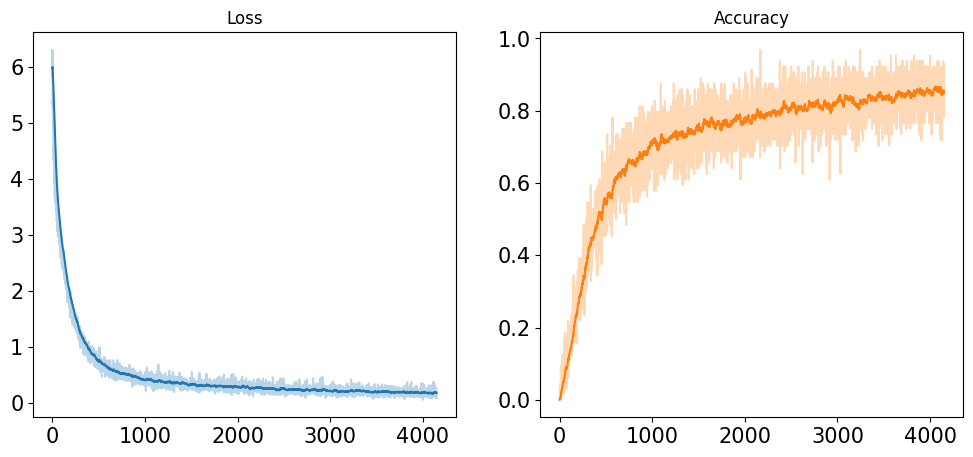

In [13]:
########################################################################
#                         START OF YOUR CODE                           #
########################################################################
ema_factor = 0.05
loss_hist_ema = np.array(loss_hist)
acc_hist_ema = np.array(accuracy_hist)
for i in range(1, len(accuracy_hist)):
    loss_hist_ema[i] = loss_hist_ema[i-1] * (1 - ema_factor) + loss_hist_ema[i] * ema_factor
    acc_hist_ema[i] = acc_hist_ema[i-1] * (1 - ema_factor) + acc_hist_ema[i] * ema_factor

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_hist_ema, color="C0")
plt.plot(loss_hist, alpha=0.3, color="C0")
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_hist_ema, color="C1")
plt.plot(accuracy_hist, alpha=0.3, color="C1")
plt.title("Accuracy")
plt.show()
########################################################################
#                          END OF YOUR CODE                            #       
########################################################################

Your plots should look similar to this:

<img align="left" src="CPC_training_10.png">

ChatGPT

Implementation of Exponential Moving Average (EMA) for the loss and accuracy histories.
The EMA is a common technique used to smooth out fluctuations in data, making trends easier to observe.

initialized by making copy of the original _hist arrays, and then updating the EMA for each element in the arrays. ema_factor is the smoothing factor, which controls how much weight is given to the new values compared to old ones.
A smaller factor (e.g., 0.05) results in more smoothing, while a larger factor (e.g., 0.1) makes the EMA more responsive to recent changes.



Alpha Blending: In the plots, the original data is plotted with an alpha value of 0.3, making it semi-transparent. This helps to compare the smoothed data (EMA) with the original data.

## Questions: 

Here are two questions regarding this implementation of CPC. Please try to answer these even if you didn't complete all of the code blocks. 

1) How can we interpret the Loss and Accuracy plots? Are they a good measure for model performance (e.g. to compare different models)? 

Your answer: The InfoNCE Loss and Accuracy plots are not a good measure for model performance here, because it depends on various model paramters that do not reflect performance. For example increasing the batch size increases the number of negative samples and thus the InfoNCE Loss, althouhgh this doesn't mean the model performs worse. 

Similarly, predicting more steps into the future will hurt the Loss and Accuracy, since it is a harder task, but lead to more useful representations being learned (when not trying to predict too far). The Accuracy depends on less model parameters than the loss here, but it is not a guarantee that useful representations have been learned. 

2) Why do we visualize the latent space `c_t`? Is our visualization a good measure for model performance? 

Your answer: Visualizing the latent space is a much better measure of model performance here, since the goal is to learn useful representations in latent space. Assuming that the first two dimensions in latent space carry a lot of the information (which seems to be the case here), we can see whether the model is able to cluster the two classes, which implies that it learned something useful about them. 

We are however only looking at a very limited number of examples from the test data, which means the plot might not be very representative. 